# Ensemble methods

In [26]:
import warnings
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve,
                             auc, precision_recall_curve, make_scorer, confusion_matrix)

# Importing the cleaned data
df = pd.read_csv('stroke_clean.csv', index_col='id')
print('Dataset: ', df.shape)
df.head()

Dataset:  (4908, 18)


,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,govt_job,never_worked,private,self-employed,children,never_smoked,formerly_smoked,smokes,unknown_smoker,stroke
id,,,,,,,,,,,,,,,,,,
9046,0,67.0,0,1,1,1,228.69,36.6,0,0,1,0,0,0,1,0,0,1
31112,0,80.0,0,1,1,0,105.92,32.5,0,0,1,0,0,1,0,0,0,1
60182,1,49.0,0,0,1,1,171.23,34.4,0,0,1,0,0,0,0,1,0,1
1665,1,79.0,1,0,1,0,174.12,24.0,0,0,0,1,0,1,0,0,0,1
56669,0,81.0,0,0,1,1,186.21,29.0,0,0,1,0,0,0,1,0,0,1


In [2]:
# Do a train-test split
x = np.array(df.loc[:, df.columns != 'stroke'])
y = np.array(df['stroke'])
test_size = 0.3

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = 41)

# Scaling the data
#scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train)
#x_test = scaler.transform(x_test)

<AxesSubplot:ylabel='Count'>

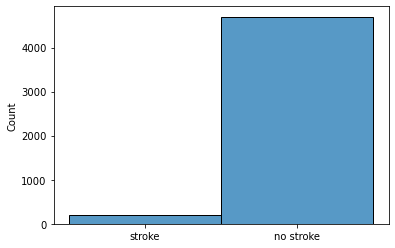

In [3]:
# Quick EDA
# Stroke = 1
# Not stroke = 0

# Dataset is very skewed, in more than one way
# We have more people without strokes than with strokes
# We have more women than men in the dataset

d = np.where(df.stroke == 1, "stroke", "no stroke")
sns.histplot(data = d)

<AxesSubplot:xlabel='gender', ylabel='Count'>

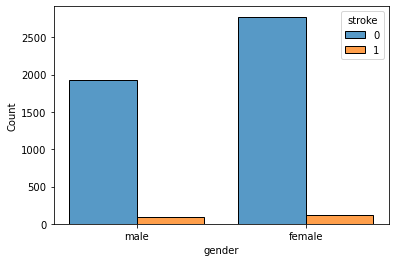

In [4]:
a = df
a.gender = np.where(df.gender == 1, "female", "male")
sns.histplot(data=a, x="gender", hue="stroke", multiple="dodge", shrink=.8)

<AxesSubplot:xlabel='age', ylabel='Count'>

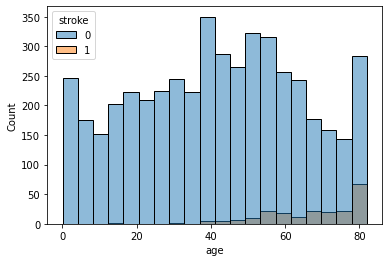

In [5]:
# Seems like an almost exponential chance of getting a stroke as you become older, based purely on data
sns.histplot(data = df, x="age", hue="stroke")

In [6]:
print("Percentage of stroke examples in dataset: ", df[df.stroke == 1].shape[0], df[df.stroke == 1].shape[0]/df.shape[0])
print("Percentage of non-stroke examples in dataset: ", df[df.stroke == 0].shape[0], df[df.stroke == 0].shape[0]/df.shape[0])
print()
print("Percentage of stroke examples in training set: ", x_train[y_train == 1].shape[0], x_train[y_train == 1].shape[0]/x_train.shape[0])
print("Percentage of non-stroke examples in training set: ", x_train[y_train == 0].shape[0], x_train[y_train == 0].shape[0]/x_train.shape[0])
print()
print("Percentage of stroke examples in test set: ", x_test[y_test == 1].shape[0], x_test[y_test == 1].shape[0]/x_test.shape[0])
print("Percentage of non-stroke examples in test set: ", x_test[y_test == 0].shape[0], x_test[y_test == 0].shape[0]/x_test.shape[0])

Percentage of stroke examples in dataset:  209 0.04258353708231459
Percentage of non-stroke examples in dataset:  4699 0.9574164629176855

Percentage of stroke examples in training set:  148 0.04308588064046579
Percentage of non-stroke examples in training set:  3287 0.9569141193595342

Percentage of stroke examples in test set:  61 0.041412084181941616
Percentage of non-stroke examples in test set:  1412 0.9585879158180584


In [7]:
# Necessary functions

# Define different scores to evaluate the models
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'f1': make_scorer(f1_score),
           'recall': make_scorer(recall_score)}

def roc(model_fit, x_test, y_test):
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model_fit.predict_proba(x_test)
    lr_probs = lr_probs[:, 1]

    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)

    # summarize scores
    print('Model: ROC AUC=%.3f' % (lr_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    # plot the roc curve for the model
    plt.figure()
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
def precision_recall(model_fit, x_test, y_test):
    lr_probs = model_fit.predict_proba(x_test)
    lr_probs = lr_probs[:, 1]
    
    # predict class values
    yhat = model_fit.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
    
    # summarize scores
    print('Model: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)

    plt.figure()
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Model')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

def train_error(model_fit):
    train_pred = model_fit.predict(x_train)

    print("Train errors:")
    print()
    print("accuracy: ", accuracy_score(y_train, train_pred))
    print("precision: ", precision_score(y_train, train_pred))
    print("recall: ", recall_score(y_train, train_pred))
    print("f1: ", f1_score(y_train, train_pred))
    print()

    #cm_train = confusion_matrix(y_train, train_pred)
    #group_names = ["TN", "FP", "FN", "TP"]
    #group_counts = ["{0:0.0f}".format(value) for value in cm_train.flatten()]
    #labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    #labels = np.asarray(labels).reshape(2,2)
    #sns.heatmap(cm_train, annot=labels, fmt = "", annot_kws={"size": 16}, linewidths = 0.5, cmap="YlGnBu")
    
def test_error(model_fit):
    test_pred = model_fit.predict(x_test)

    print("Test errors:")
    print()
    print("accuracy: ", accuracy_score(y_test, test_pred))
    print("precision: ", precision_score(y_test, test_pred))
    print("recall: ", recall_score(y_test, test_pred))
    print("f1: ", f1_score(y_test, test_pred))

    cm_test = confusion_matrix(y_test, test_pred)
    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in cm_test.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm_test, annot=labels, fmt = "", annot_kws={"size": 16}, linewidths = 0.5, cmap="YlGnBu")

### How to evaluate performance?

Write about ROC, Precision-recall, accuracy, precision, recall and f1. We cannot use gridsearch CV to optimize for anything other than accuracy, as it will not give the expected results. When we decide how we will evaluate the functions, then write your own grid search algorithm which favors the minority class.

### Decision tree

Implement a simple decision tree to test the GridSeachCV and get a baseline error. We do a grid search over the parameters criterion, max_depth, min_samples_split and min_samples_leaf. We also look at the different trees using different refit scoring.

In [8]:
warnings.filterwarnings('ignore')

parameters = {'criterion': ('gini', 'entropy'),      # Function to measure quality of split
              'max_depth': range(1, 10, 1),          # The maximum depth of the tree
              'min_samples_split': range(2, 10, 1),  # The minimum number of samples required to split an internal node
              'min_samples_leaf': range(1, 10, 1)}   # The minimum number of samples required to be at a leaf node

clf = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 41),
                   param_grid = parameters,
                   scoring = "accuracy",
                   cv = 5)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_
print(best_params)

warnings.filterwarnings('always')

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


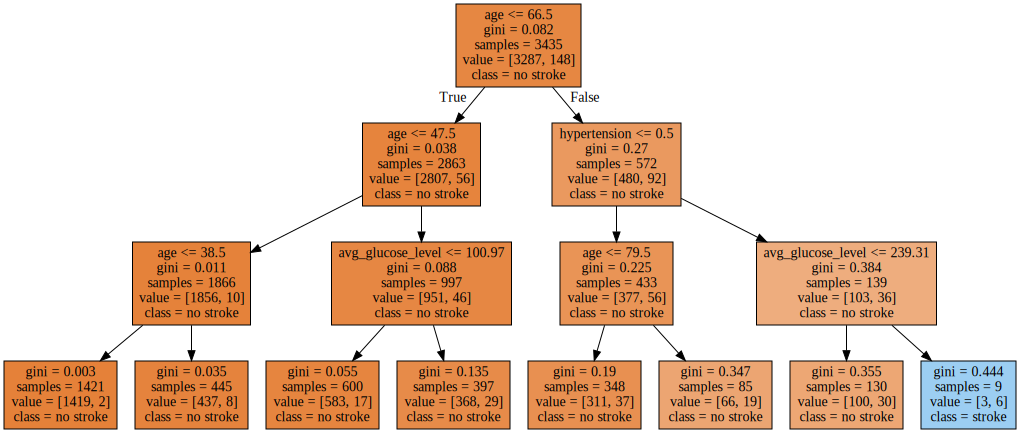

In [9]:
# Add best params into the function
tree = DecisionTreeClassifier(**best_params)
tree_fit = tree.fit(x_train, y_train)

display(graphviz.Source(export_graphviz(tree_fit, feature_names = df.columns[:-1], filled = True, class_names = ("no stroke", "stroke"))))

Model: ROC AUC=0.822


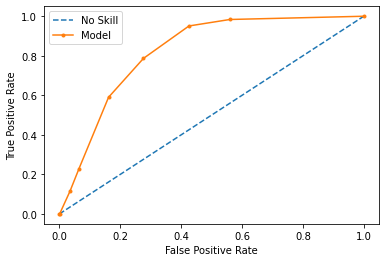

In [10]:
roc(model_fit = tree_fit, x_test = x_test, y_test = y_test)

Model: f1=0.000 auc=0.115


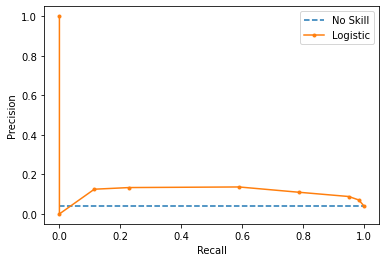

In [11]:
precision_recall(model_fit = tree_fit, x_test = x_test, y_test = y_test)

Train errors:

accuracy:  0.9577874818049491
precision:  0.6666666666666666
recall:  0.04054054054054054
f1:  0.07643312101910829

Test errors:

accuracy:  0.957909029192125
precision:  0.0
recall:  0.0
f1:  0.0


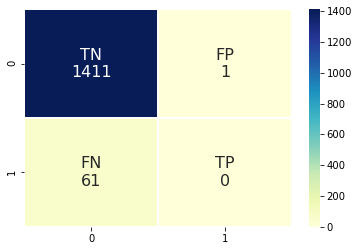

In [12]:
train_error(model_fit = tree_fit)
test_error(model_fit = tree_fit)

We have too many false negatives. Dangerous! Maybe use "recall" as measure with this dataset? Or f1? Accuracy is good in cases where we have equal size classes and false negatives and false positives are of equal importance. Prediction is good when we want to minimize the cases of true positives. Recall is good when we want to minimize the cases of false negatives. F1 takes into account both precision and recall. In our case it might be better to predict that someone will have a stroke even if that will not be the case, compared to the opposite.

\begin{align*}
    \text{accuracy} = \frac{\text{tp + tn}}{\text{tp + tn + fn + fp}}
\end{align*}

\begin{align*}
    \text{precision} = \frac{\text{tp}}{\text{tp + fp}}
\end{align*}

\begin{align*}
    \text{recall} = \frac{\text{tp}}{\text{tp + fn}}
\end{align*}

\begin{align*}
    \text{f1} = \frac{2\cdot \text{precision} \cdot \text{recall}}{\text{precision + recall}}
\end{align*}

Accuracy is around $95\%$ with a single deicison tree. If we do grid search with regards to accuracy, all the other measures becomes zero.

Future: add some plots of the hyperparameter tuning process maybe?

### Random Forest

Try to fit a random forest model to the stroke classification problem. Use cross-validation grid search to find the optimal parameters.

In [13]:
np.random.seed(41)
warnings.filterwarnings('ignore')

parameters = {'n_estimators': [10, 30, 50, 100],
              'max_features': (2, 'sqrt', 8, 12),
              'max_depth': range(1, 10, 1)}

clf = GridSearchCV(estimator = RandomForestClassifier(random_state=41,
                                                      criterion='gini',
                                                      bootstrap=True,
                                                      oob_score=False),
                  param_grid = parameters,
                  scoring = "accuracy",
                  cv = 5,
                  return_train_score = True)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_
print(best_params)

warnings.filterwarnings('always')

{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 50}


Train errors:

accuracy:  0.9624454148471616
precision:  1.0
recall:  0.12837837837837837
f1:  0.22754491017964074

Test errors:

accuracy:  0.9585879158180584
precision:  0.0
recall:  0.0
f1:  0.0


C:\Users\elveb\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


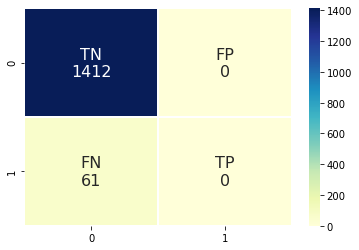

In [14]:
rf = RandomForestClassifier(**best_params)
rf_fit = rf.fit(x_train, y_train)

train_error(model_fit = rf_fit)
test_error(model_fit = rf_fit)

Model: ROC AUC=0.800


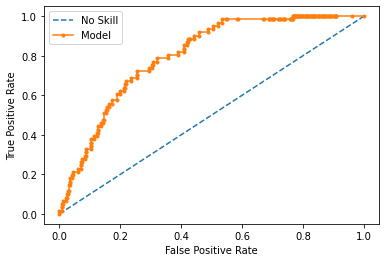

In [15]:
roc(model_fit = rf_fit, x_test = x_test, y_test = y_test)

Model: f1=0.000 auc=0.132


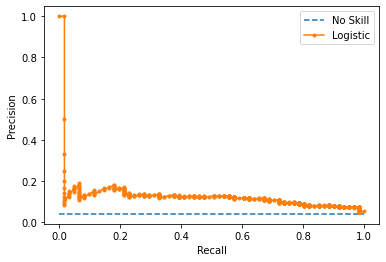

In [16]:
precision_recall(model_fit = rf_fit, x_test = x_test, y_test = y_test)

### Weighted Random Forest

Try a weighted random forest to even out the imbalanced classes. The weighted random forest works bu changing the weight the each class has when calculating the impurity score at each split. When the data has a skewed class distribution the impurity calculating becomes biased such that false negatives for the majority class is permitted.

From using random forest to learn imbalanced data: Another approach to make random forest more suitable for learning from extremely imbalanced data follows the idea of cost sensitive learning. Since the RF classifier tends to be biased towards the majority class, we shall place a heavier penalty on misclassifying the minority class.

In python this can easily be achieved by using argument "class_weight". The value "balanced" uses the inverse weighting from the training dataset, giving focus to the minority class. Using the value "balanced_subsample" instead, the class weighting changes based on the class distribution in each bootstrap sample, instead of the entire dataset. As we expect the bootstrap samples to contain even fewer classifications of stroke, we use the "balance_subsample value" when training the weighted random forest.

In [17]:
np.random.seed(41)
warnings.filterwarnings('ignore')

parameters = {'n_estimators': [10, 30, 50],
              'max_features': (2, 'sqrt', 8),
              'max_depth': range(1, 3, 1)}

clf = GridSearchCV(estimator = RandomForestClassifier(random_state=41,
                                                      criterion='gini',
                                                      class_weight = 'balanced_subsample',
                                                      bootstrap=True,
                                                      oob_score=False),
                  param_grid = parameters,
                  scoring = "accuracy",
                  cv = 5,
                  return_train_score = True)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_
print(best_params)

warnings.filterwarnings('always')

{'max_depth': 1, 'max_features': 2, 'n_estimators': 10}


Train errors:

accuracy:  0.9569141193595342
precision:  0.0
recall:  0.0
f1:  0.0

Test errors:

accuracy:  0.9585879158180584
precision:  0.0
recall:  0.0
f1:  0.0


C:\Users\elveb\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elveb\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


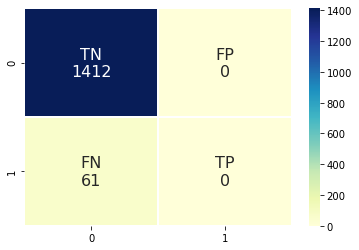

In [18]:
wrf = RandomForestClassifier(**best_params)
wrf_fit = wrf.fit(x_train, y_train)

train_error(model_fit = wrf_fit)
test_error(model_fit = wrf_fit)

Model: ROC AUC=0.784


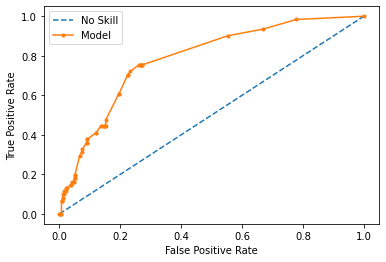

In [19]:
roc(model_fit = wrf_fit, x_test = x_test, y_test = y_test)

Model: f1=0.000 auc=0.125


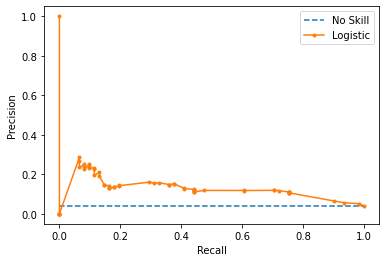

In [20]:
precision_recall(model_fit = wrf_fit, x_test = x_test, y_test = y_test)

### Balanced Random Forest

We get a small improvement in the wrf compared to the rf. An even bigger improvement can be made if we use the Balanced Random Forest. The method works by randomly undersampling from the majority class during the bootstrap sampling.  

The implementation of the BRF is from a python library called imbalanced-learn which offers a number of resampling techniques commenyl used in datasets showing strong between-class imbalance: https://pypi.org/project/imbalanced-learn/.

In [21]:
np.random.seed(41)

parameters = {'n_estimators': [10, 30, 50],
              'max_features': (2, 'sqrt', 8),
              'max_depth': range(1, 3, 1)}

clf = GridSearchCV(estimator = BalancedRandomForestClassifier(random_state=41,
                                                              criterion='gini',
                                                              class_weight = 'balanced_subsample',
                                                              bootstrap=True,
                                                              oob_score=False),
                  param_grid = parameters,
                  scoring = "accuracy",
                  cv = 5,
                  return_train_score = True)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_
print(best_params)

{'max_depth': 2, 'max_features': 2, 'n_estimators': 10}


Train errors:

accuracy:  0.9569141193595342
precision:  0.0
recall:  0.0
f1:  0.0

Test errors:

accuracy:  0.9585879158180584
precision:  0.0
recall:  0.0
f1:  0.0


C:\Users\elveb\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elveb\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


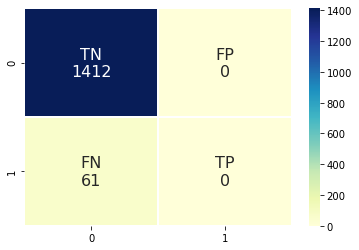

In [22]:
brf = RandomForestClassifier(**best_params)
brf_fit = brf.fit(x_train, y_train)

train_error(model_fit = brf_fit)
test_error(model_fit = brf_fit)

Model: ROC AUC=0.794


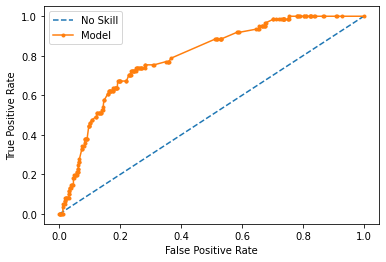

In [23]:
roc(model_fit = brf_fit, x_test = x_test, y_test = y_test)

Model: f1=0.000 auc=0.121


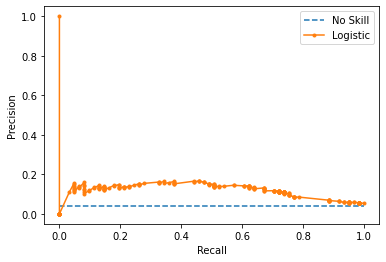

In [24]:
precision_recall(model_fit = brf_fit, x_test = x_test, y_test = y_test)

### Gradient boosting

Train errors:

accuracy:  0.9665211062590975
precision:  1.0
recall:  0.22297297297297297
f1:  0.3646408839779005

Test errors:

accuracy:  0.9545145960624576
precision:  0.0
recall:  0.0
f1:  0.0


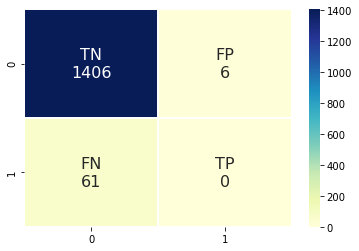

In [25]:
gb = GradientBoostingClassifier(random_state = 41)
gb_fit = gb.fit(x_train, y_train)

train_error(model_fit = gb_fit)
test_error(model_fit = gb_fit)

### XgBoost

Try to implement XGBoost to make performance better.

C:\Users\elveb\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:11:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train errors:

accuracy:  0.9697234352256187
precision:  1.0
recall:  0.2972972972972973
f1:  0.4583333333333333

Test errors:

accuracy:  0.9531568228105907
precision:  0.1
recall:  0.01639344262295082
f1:  0.028169014084507043


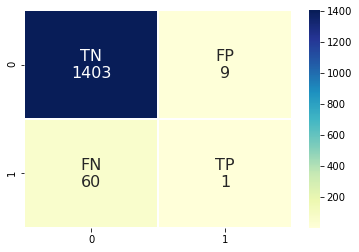

In [27]:
xgb_model = xgb.XGBClassifier(n_estimators = 100,
                       reg_lambda = 1,
                       gamma = 0,
                       max_depth = 3)
xgb_fit = xgb_model.fit(x_train, y_train)

train_error(model_fit = xgb_fit)
test_error(model_fit = xgb_fit)

In [28]:
# Importance of each feature

pd.DataFrame(xgb_model.feature_importances_.reshape(1, -1), columns=df.columns[:-1])

,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,govt_job,never_worked,private,self-employed,children,never_smoked,formerly_smoked,smokes,unknown_smoker
0,0.08172,0.158052,0.088579,0.089186,0.058376,0.072123,0.056278,0.059448,0.063808,0.0,0.048306,0.047325,0.0,0.092377,0.008814,0.02756,0.048047


### Interpreting the results: XAI

Which packages do we need to do this? pdpbox, alepython, lime...

Global methods:
* Linear model (standardized coeffs, shapley regression)
* XGBoost/RF (gini importance)
* Partial dependence plots
* ALE plots

Local methods:
* LIME
* Shapley
* Counterfactual explanations

Links:
* https://machinelearningmastery.com/feature‐importance‐and‐feature‐selection‐with‐xgboost‐in‐python/

In [29]:
import lime
import pdpbox